# Sales Forecasting

## Indentitas Pembuat
```txt
Nama : Andre Lie
Jabatan : Pelajar
Program : Full Time Data Science Batch 003 Offline
Institusi : Hacktiv8
```

## Tujuan

Tujuan dibuat project ini adalah untuk memprediksikan berapa besar sales setiap produk dalam 14 hari kedepan. untuk mencapai tujuan dari project ini berikut merupakan hal-hal yang perlu kita cari tau terlebih dahulu yaitu
* Bagaimana gambaran penjualan saat ini ?
* Produk apa yang merupakan pareto sales berdasarkan data ?

## Memasukan Perpustakaan

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import warnings

## Pengaturan

In [338]:
warnings.filterwarnings('ignore')

## Memuat Data

saat pengecheckan data terdapat beberapa sheet pada dataset, sehingga perlu kita gabungkan kedalam 1 sheet terlebih dahulu agar lebih mudah untuk dilakukan pengolahan.

In [339]:
df1 = pd.read_excel('kalbe_dataset.xlsx', sheet_name='A1') # memuat sheet 1
df2 = pd.read_excel('kalbe_dataset.xlsx', sheet_name='A2') # memuat sheet 2
df3 = pd.read_excel('kalbe_dataset.xlsx', sheet_name='B1') # memuat sheet 3
df4 = pd.read_excel('kalbe_dataset.xlsx', sheet_name='B2') # memuat sheet 4
df_ori = pd.concat([df1, df2, df3, df4]) # mengabungkan sheet 1 - 4
df_ori

,Day,Category,Product,Sales,Event
0,1,A,A1,100.000000,NaN
1,2,A,A1,101.000000,NaN
2,3,A,A1,102.010000,NaN
3,4,A,A1,103.030100,NaN
4,5,A,A1,104.060401,NaN
...,...,...,...,...,...
99,100,B,B2,NaN,NaN
100,101,B,B2,NaN,NaN
101,102,B,B2,NaN,NaN
102,103,B,B2,NaN,NaN


membuat salinan data untuk dipakai bekerja, sehingga jika dibutuhkan data awal tidak harus memuat data kembali.

In [340]:
df = df_ori.copy() # menyalin data

## Eksplorasi Data Analisis (EDA)

In [341]:
df.info() # menampilkan informasi dari dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 103
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       388 non-null    int64  
 1   Category  388 non-null    object 
 2   Product   388 non-null    object 
 3   Sales     300 non-null    float64
 4   Event     104 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.2+ KB


Total pengisian data adalah 388 sedangkan pada kolom sales hanya 300 dan kolom event 104 data yang berarti adanya data kosong pada kedua kolom tersebut. Pada kolom event perlu dicheck kembali juga mengapa datanya berupa angka.

In [342]:
df.groupby('Event')['Product'].value_counts() # menampilkan product yang memiliki data dari kolom event

Event  Product
0.0    B1         92
1.0    B1         12
Name: Product, dtype: int64

Kolom event dimiliki nilainya oleh produk B1 dan memiliki nilai 0 dan 1. dapat diasuksikan bahwa kolom event menunjukan dilakukan event untuk produk tersebut atau tidak, dimana "tidak dilakukan" ditunjukan dengan angka 0 dan "dilakukan" ditunjukan dengan angka 1.

dikarenakan hanya product B1 yang memiliki kolom event, maka data menjadi tidak relevan jika dipakai dalam membut model untuk produk yang lain sehingga kedepannya perlu kita drop kolomnya.

### Bagaimana gambaran penjualan saat ini ?

Product
A1    AxesSubplot(0.125,0.11;0.775x0.77)
A2    AxesSubplot(0.125,0.11;0.775x0.77)
B1    AxesSubplot(0.125,0.11;0.775x0.77)
B2    AxesSubplot(0.125,0.11;0.775x0.77)
Name: Sales, dtype: object

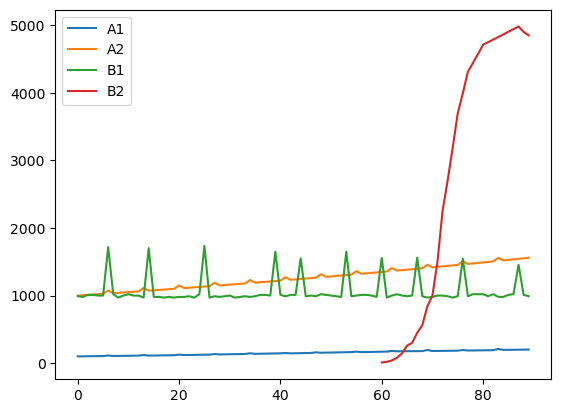

In [343]:
grp_prd = df.groupby('Product')['Sales'] # mengkategorikan penjualan berdasarkan produknya
grp_prd.plot(kind='line', legend=True) # membuat gambaran penjualan

In [344]:
df[(df['Event'] > 0)] # menampilkan data saat dilakukan event

,Day,Category,Product,Sales,Event
6,7,B,B1,1717.0,1.0
14,15,B,B1,1700.0,1.0
25,26,B,B1,1734.0,1.0
39,40,B,B1,1649.0,1.0
44,45,B,B1,1550.0,1.0
53,54,B,B1,1650.0,1.0
60,61,B,B1,1555.0,1.0
67,68,B,B1,1560.0,1.0
76,77,B,B1,1545.0,1.0
87,88,B,B1,1455.0,1.0


In [345]:
grp_prd.min() # menampilkan nilai minimal dari tiap produk

Product
A1     100.0
A2    1000.0
B1     970.0
B2      10.0
Name: Sales, dtype: float64

In [346]:
grp_prd.max() # menampilkan nilai minimal dari tiap produk

Product
A1     210.000000
A2    1558.760875
B1    1734.000000
B2    4980.657414
Name: Sales, dtype: float64

Insight :
1. Produk A1 mengalami kenaikan penjualan tetapi sangat kecil selama 90 hari terakhir
2. Produk A2 mengalami kenaikan penjualan yang signifikan yaitu sekitar 50% dari awal penjualan
3. Jika berdasarkan data sebelumnya, untuk produk B1 sepertinya terjual hanya saat event. dapat dilihat jumlah lonjakan penjualan produk yang hanya terjadi pada hari yang sama dengan event.
4. Sedangkan untuk produk B2 yang baru saja di launching langsung mengalami kenaikan penjualan yang sangat signifikan yaitu mencapai 498% dari awal penjualan.

### Produk apa yang merupakan pareto sales berdasarkan data ?

In [347]:
df.groupby('Product')['Sales'].sum()/df['Sales'].sum()*100 # menampilkan persetase penjualan tiap produk terhadap total penjualan

Product
A1     4.436500
A2    37.211546
B1    31.270842
B2    27.081112
Name: Sales, dtype: float64

Dari data yang diperoleh, produk pareto / produk dengan 85% total penjualan adalah Produk A2, B1, & B2.

## Penyiapan Data

### Menanggani data kosong

In [348]:
df.isnull().sum() # menampilkan jumlah data kosong pada tiap kolom

Day           0
Category      0
Product       0
Sales        88
Event       284
dtype: int64

dikarenakan kolom event sudah tidak dibutuhkan, maka dapat kita hilangkan.

In [349]:
df.drop('Event', inplace=True, axis=1) # menghilangkan kolom event dari dapat set kita.
df

,Day,Category,Product,Sales
0,1,A,A1,100.000000
1,2,A,A1,101.000000
2,3,A,A1,102.010000
3,4,A,A1,103.030100
4,5,A,A1,104.060401
...,...,...,...,...
99,100,B,B2,NaN
100,101,B,B2,NaN
101,102,B,B2,NaN
102,103,B,B2,NaN


In [350]:
df[df['Sales'].isnull()]['Product'].value_counts() # mengecheck dimana letak data kosong berdasarkan produknya

B2    74
B1    14
Name: Product, dtype: int64

terlihat bahwa data kosong berada produk B1 dan B2, dimana kita tau diawal bahwa B1 adalah produk yang penjualannya naik seiring dengan event and B2 kemungkinan besar adalah produk yang baru launching. sehingga untuk penangannya B1 akan diinput dengan nilai minnya, dan data B2 sebelum launching akan di hapus.

In [351]:
df.loc[(df['Product'] == 'B1') & (df['Sales'].isnull()), 'Sales'] = df[df['Product'] == 'B1']['Sales'].min()  # mengganti data kosong pada produk B1 dengan 0

In [352]:
df.dropna(inplace=True) # menghapus data kosong pada produk B2

In [353]:
df[df['Sales'].isnull()]['Product'].value_counts() # mengecheck kembali data kosong

Series([], Name: Product, dtype: int64)

sekarang data yang kita miliki sudah tidak terdapat data kosong lagi.

### Pengecheckan Autocorrelation Data

tujuan pengecekan ini adalah untuk melihat apakah data yang kita punya memiliki hubungan seiring berjalannya waktu atau tidak.

In [354]:
# Membuat data day dan sales berdasarkan produk
df_a1 = df[(df['Product'] == 'A1')] # Mengelompokan produk A1
df_a1 = df_a1[['Day', 'Sales']] # mengambil data day dan sales
df_a1 = df_a1.set_index('Day') # mengubah data day menjadi index
df_a1 = df_a1.Sales # mengubah dataframe menjadi list

df_a2 = df[(df['Product'] == 'A2')] # Mengelompokan produk A2
df_a2 = df_a2[['Day', 'Sales']]
df_a2 = df_a2.set_index('Day')
df_a2 = df_a2.Sales

df_b1 = df[(df['Product'] == 'B1')] # Mengelompokan produk B1
df_b1 = df_b1[['Day', 'Sales']]
df_b1 = df_b1.set_index('Day')
df_b1 = df_b1.Sales

df_b2 = df[(df['Product'] == 'B2')] # Mengelompokan produk B2
df_b2 = df_b2[['Day', 'Sales']]
df_b2 = df_b2.set_index('Day')
df_b2 = df_b2.Sales

df_a1

Day
1     100.000000
2     101.000000
3     102.010000
4     103.030100
5     104.060401
         ...    
86    196.980000
87    197.964900
88    198.954724
89    199.949498
90    200.949246
Name: Sales, Length: 90, dtype: float64

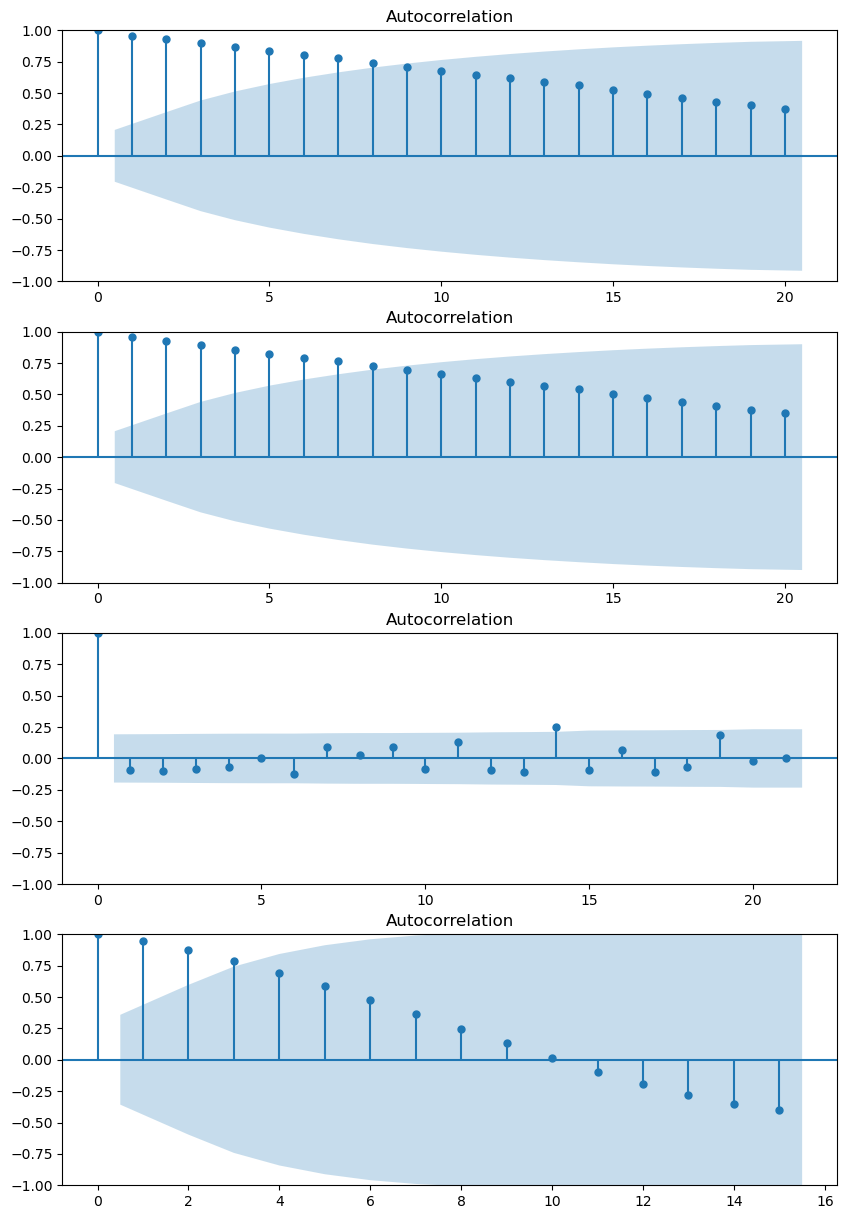

In [355]:
fig, axes = plt.subplots(nrows=4, figsize=(10,15))
acf_plot_a1 = plot_acf(df_a1, ax=axes[0]) # menampilkan grafik autocorelation produk A1
acf_plot_a2 = plot_acf(df_a2, ax=axes[1]) # menampilkan grafik autocorelation produk A2
acf_plot_b1 = plot_acf(df_b1, ax=axes[2]) # menampilkan grafik autocorelation produk B1
acf_plot_b2 = plot_acf(df_b2, ax=axes[3]) # menampilkan grafik autocorelation produk B2

pada grafik diatas banya titik berada pada area biru di setiap produknya, ini menandakan adanya hubungan data sales yang kita punya seiring berjalannya waktu.

## Pembuatan Model

### Membagi data menjadi data train dan data test

In [356]:
train_a1 = df_a1[:60] # mengambil data sebagai data train dari produk A1
test_a1 = df_a1[60:] # mengambil data sebagai data test dari produk A1

train_a2 = df_a2[:60] # mengambil data sebagai data train dari produk A2
test_a2 = df_a2[60:] # mengambil data sebagai data test dari produk A2

train_b1 = df_b1[:60] # mengambil data sebagai data train dari produk B1
test_b1 = df_b1[60:] # mengambil data sebagai data test dari produk B1

train_b2 = df_b2[:20] # mengambil data sebagai data train dari produk B2
test_b2 = df_b2[20:] # mengambil data sebagai data test dari produk B2

Dikarenakan data B2 hanya ada 30 data terakhir, maka pengambilan data pada produk B2 sedikit berbeda dengan data A1, A2, dan B1 tetapi tetap memperhatikan proprosi data yaitu train:test = 2 : 1.

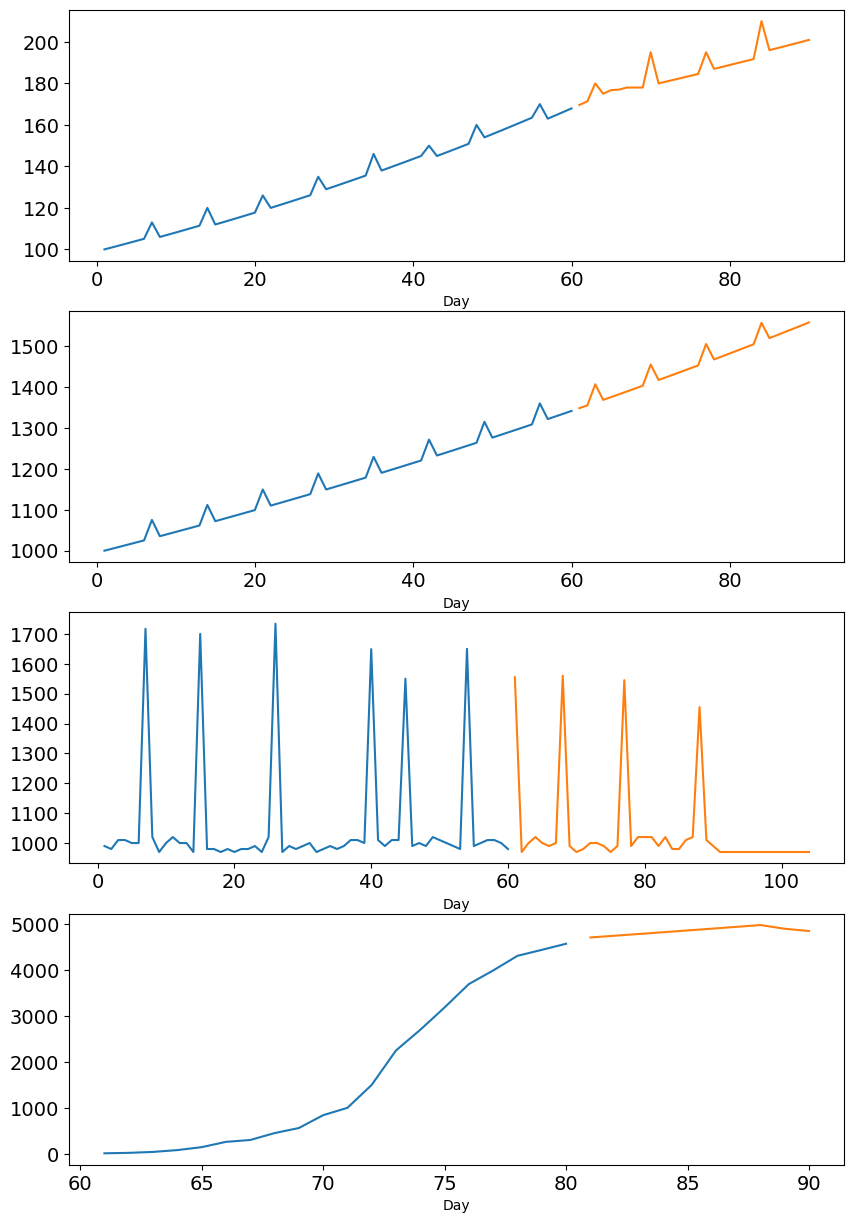

In [357]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 15))
train_a1.plot(fontsize=14, ax=axes[0])
test_a1.plot(fontsize=14, ax=axes[0])
train_a2.plot(fontsize=14, ax=axes[1])
test_a2.plot(fontsize=14, ax=axes[1])
train_b1.plot(fontsize=14, ax=axes[2])
test_b1.plot(fontsize=14, ax=axes[2])
train_b2.plot(fontsize=14, ax=axes[3])
test_b2.plot(fontsize=14, ax=axes[3])
plt.show()

## Membuat & Melatih Model Auto Regressive

In [358]:
# melatih model menggunakan train
model_a1 = ARIMA(train_a1, order=(8,0,0)).fit()
model_a2 = ARIMA(train_a2, order=(8,0,0)).fit()
model_b1 = ARIMA(train_b1, order=(8,0,0)).fit()
model_b2 = ARIMA(train_b2, order=(8,0,0)).fit()

In [413]:
# memprediksi hasil tiap model
prediksi_a1 = model_a1.predict(start=test_a1.index[0], end=test_a1.index[-1])
prediksi_a2 = model_a2.predict(start=test_a2.index[0], end=test_a2.index[-1])
prediksi_b1 = model_b1.predict(start=test_b1.index[0], end=test_b1.index[-1])
prediksi_b2 = model_b2.predict(start=test_b2.index[0], end=test_b2.index[-1])

Text(0.5, 1.0, 'Model B2')

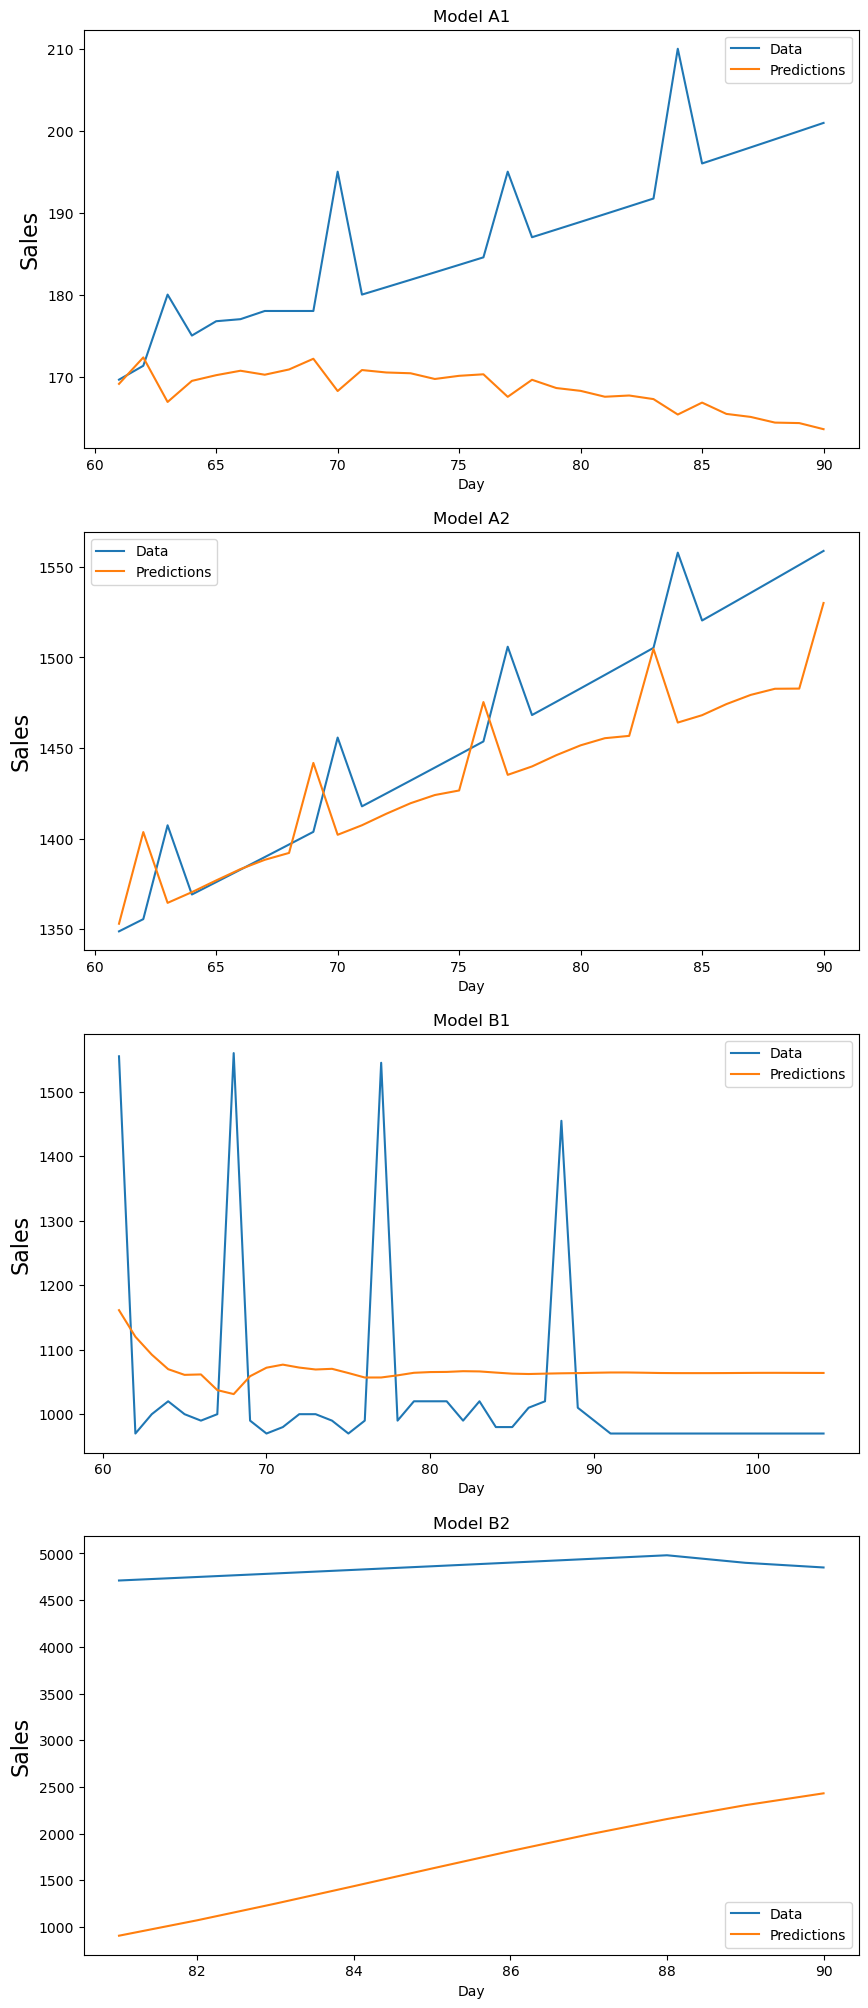

In [414]:
# melakukan visualisasi data antara hasil prediksi dengan data test
fig, axes = plt.subplots(nrows=4, figsize=(10,25))

test_a1.plot(ax=axes[0])
prediksi_a1.plot(ax=axes[0])
axes[0].legend(('Data', 'Predictions'), fontsize=10)
axes[0].set_ylabel('Sales', fontsize=16)
axes[0].set_title('Model A1')

test_a2.plot(ax=axes[1])
prediksi_a2.plot(ax=axes[1])
axes[1].legend(('Data', 'Predictions'), fontsize=10)
axes[1].set_ylabel('Sales', fontsize=16)
axes[1].set_title('Model A2')

test_b1.plot(ax=axes[2])
prediksi_b1.plot(ax=axes[2])
axes[2].legend(('Data', 'Predictions'), fontsize=10)
axes[2].set_ylabel('Sales', fontsize=16)
axes[2].set_title('Model B1')

test_b2.plot(ax=axes[3])
prediksi_b2.plot(ax=axes[3])
axes[3].legend(('Data', 'Predictions'), fontsize=10)
axes[3].set_ylabel('Sales', fontsize=16)
axes[3].set_title('Model B2')

terlihat bahwa model A1, B1, dan B2 belum cukup baik untuk memprediksikan nilai sales, sedangkan untuk model A2 sudah hampir mengikuti pola penjualan aktual.

## Membuat & Melatih Model Exponential

In [378]:
# melatih model menggunakan train
exp_model_a1 = ExponentialSmoothing(train_a1, seasonal_periods=3, trend='additive', seasonal='multiplicative').fit()
exp_model_a2 = ExponentialSmoothing(train_a2, seasonal_periods=3, trend='additive', seasonal='multiplicative').fit()
exp_model_b1 = ExponentialSmoothing(train_b1, seasonal_periods=3, trend='additive', seasonal='multiplicative').fit()
exp_model_b2 = ExponentialSmoothing(train_b2, seasonal_periods=3, trend='additive', seasonal='multiplicative').fit()

In [382]:
# memprediksi hasil tiap model
prediksi_a1_exp = exp_model_a1.forecast(len(test_a1))
prediksi_a2_exp = exp_model_a2.forecast(len(test_a2))
prediksi_b1_exp = exp_model_b1.forecast(len(test_b1))
prediksi_b2_exp = exp_model_b2.forecast(len(test_b2))

Text(0.5, 1.0, 'Model B2')

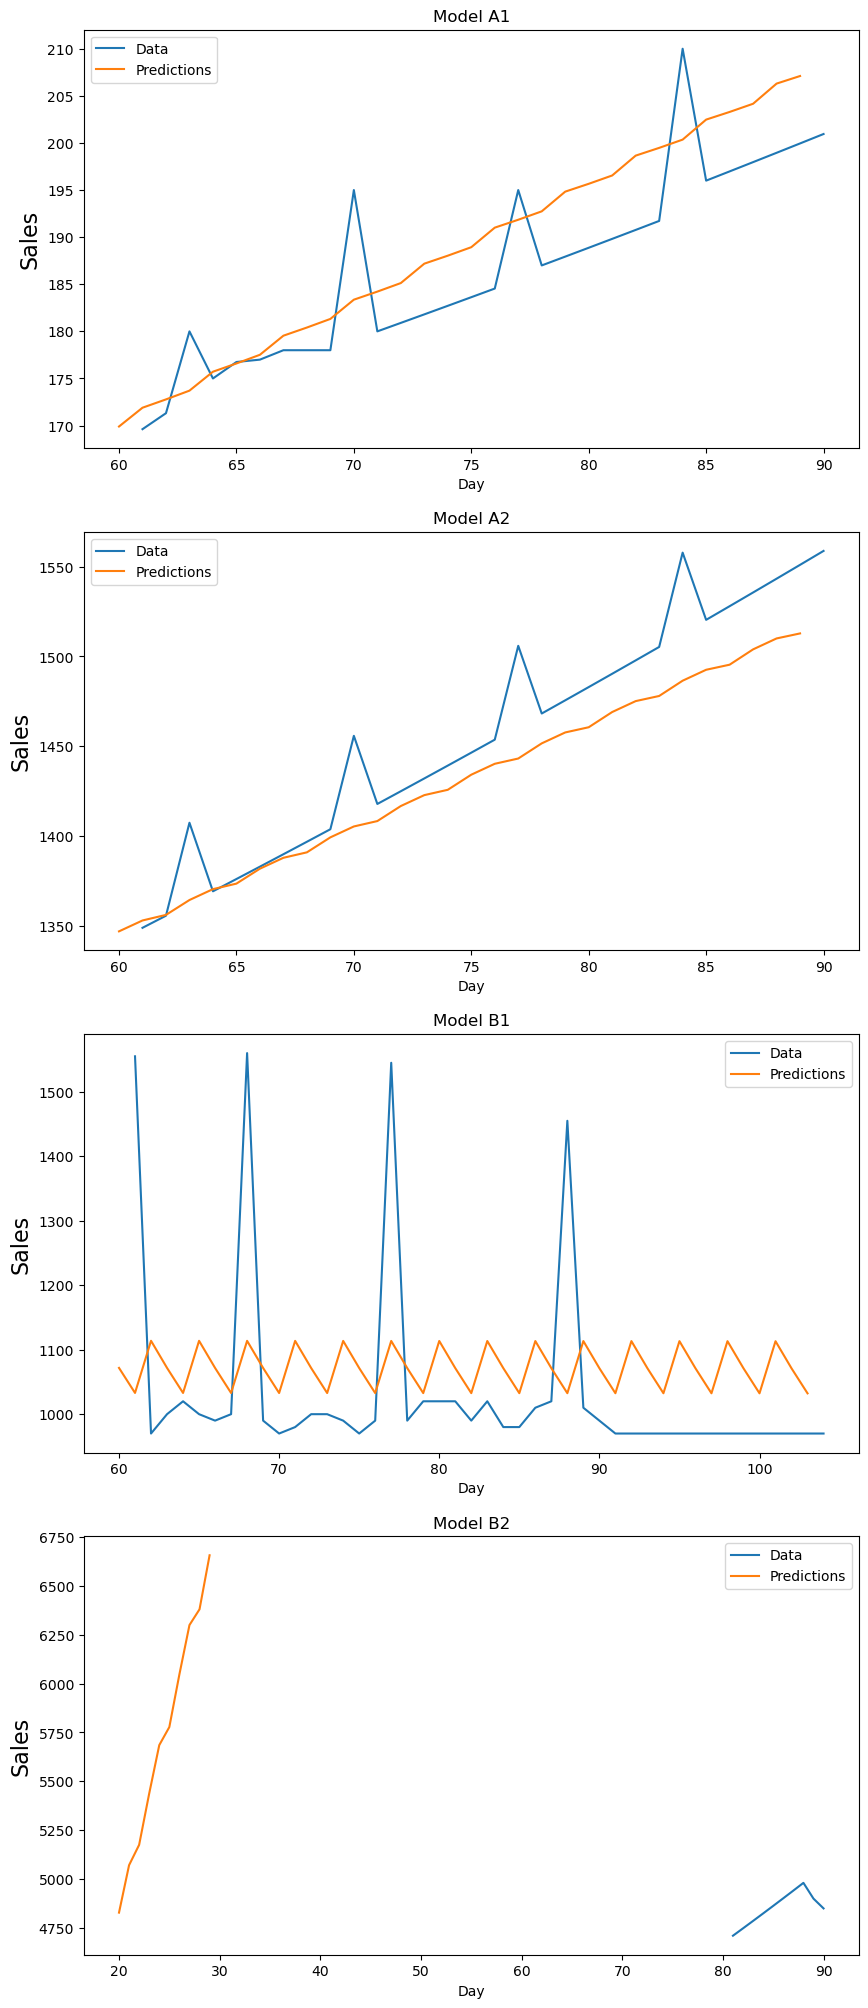

In [383]:
# melakukan visualisasi data antara hasil prediksi dengan data test
fig, axes = plt.subplots(nrows=4, figsize=(10,25))

test_a1.plot(ax=axes[0])
prediksi_a1_exp.plot(ax=axes[0])
axes[0].legend(('Data', 'Predictions'), fontsize=10)
axes[0].set_ylabel('Sales', fontsize=16)
axes[0].set_title('Model A1')

test_a2.plot(ax=axes[1])
prediksi_a2_exp.plot(ax=axes[1])
axes[1].legend(('Data', 'Predictions'), fontsize=10)
axes[1].set_ylabel('Sales', fontsize=16)
axes[1].set_title('Model A2')

test_b1.plot(ax=axes[2])
prediksi_b1_exp.plot(ax=axes[2])
axes[2].legend(('Data', 'Predictions'), fontsize=10)
axes[2].set_ylabel('Sales', fontsize=16)
axes[2].set_title('Model B1')

test_b2.plot(ax=axes[3])
prediksi_b2_exp.plot(ax=axes[3])
axes[3].legend(('Data', 'Predictions'), fontsize=10)
axes[3].set_ylabel('Sales', fontsize=16)
axes[3].set_title('Model B2')

dapat dilihat bahwa model exponetial lebih tidak dapat mengikuti pola penjualan sehingga tidak mungkin untuk dipakai.

## Model Evaluasi

In [421]:
# model Autoregresive
print('Presentase akurasi model')
print(f'Model A1 (Auto Regresive) : {100 - mean_absolute_percentage_error(test_a1, prediksi_a1)}%')
print(f'Model A2 (Auto Regresive) : {100 - mean_absolute_percentage_error(test_a2, prediksi_a2)}%')
print(f'Model B1 (Auto Regresive) : {100 - mean_absolute_percentage_error(test_b1, prediksi_b1)}%')
print(f'Model B2 (Auto Regresive) : {100 - mean_absolute_percentage_error(test_b2, prediksi_b2)}%')

Presentase akurasi model
Model A1 (Auto Regresive) : 99.90428654226491%
Model A2 (Auto Regresive) : 99.9790331856704%
Model B1 (Auto Regresive) : 99.90043967776317%
Model B2 (Auto Regresive) : 99.34908533744283%


In [422]:
# model Exponential
print('Presentase akurasi model')
print(f'Model A1 (Exponential) : {100 - mean_absolute_percentage_error(test_a1, prediksi_a1_exp)}%')
print(f'Model A2 (Exponential) : {100 - mean_absolute_percentage_error(test_a2, prediksi_a2_exp)}%')
print(f'Model B1 (Exponential) : {100 - mean_absolute_percentage_error(test_b1, prediksi_b1_exp)}%')
print(f'Model B2 (Exponential) : {100 - mean_absolute_percentage_error(test_b2, prediksi_b2_exp)}%')

Presentase akurasi model
Model A1 (Exponential) : 99.97667283899531%
Model A2 (Exponential) : 99.98191914526346%
Model B1 (Exponential) : 99.8921806785158%
Model B2 (Exponential) : 99.81882582459369%


walaupun setelah diukur akurasi model terdahap hasil yang dibuat mendekati nilai rata-rata penjualan sebenarnya tetapi model yang dibuat tidak dapat mengikuti pola / trend penjualan yang ada sehingga kedua model belum dapat dikatakan baik.

## Kesimpulan

1. Produk A1 mengalami kenaikan penjualan tetapi sangat kecil selama 90 hari terakhir.
2. Produk A2 mengalami kenaikan penjualan yang signifikan yaitu sekitar 50% dari awal penjualan.
3. Produk B1 adalah produk yang penjualannya naik saat ada event.
4. Produk B2 adalah produk yang baru dilaunching kepasaran dan memiliki potensi penjual yang baik selama 30 hari terakhir.
5. Produk yang menjadi pareto penjualan saat ini adalah Produk A2, B1, dan B2.
6. Model yang dibuat belum dapat memprediksikan hasil penjualan dengan baik dan cenderung masih underfit, walaupun nilai akurasinya terhadap penjualan rata-rata mencapai 99%.

## Perbaikan selanjutnya

1. Datanya perlu dicoba untuk melihat stationerynya (rata-rata per periode waktu), karena model perlu belajar dari data yang stationernya stabil.
2. Perlu dicoba juga model-model yang dapat menyesuaikan dengan dataset seperti SariMax, dan dicari parameter yang tepat.
3. Perlu difokuskan peningkatan penjualan terhadap produk, produk pareto seperti A2, B1, dan B2, sehingga sales dapat lebih meningkat.